# Fantasy Baseball Pandas Analysis

This takes a number of inputs and produces fantasy scores for each player.

In [14]:
import requests
import csv
import datetime
import subprocess
import pandas as pd
import numpy as np
import seaborn as sb
from bs4 import BeautifulSoup
pd.options.display.max_columns = 150

## Get Roster Data

This will rip the roster information from ESPN and save it to a local CSV file.

In [2]:
LEAGUE_URL = "http://games.espn.com/flb/leaguerosters?leagueId={league_id}"
LEAGUE_ID = 15594

# translate ESPN names to Fangraphs names.
# Add new names as required, since name is used to join the data sets.
TRANSLATIONS = {
    'Nicky Delmonico': 'Nick Delmonico',
    'Yuli Gurriel': 'Yulieski Gurriel'
}


rosters_html = requests.get(LEAGUE_URL.format(league_id=LEAGUE_ID)).text
rosters_soup = BeautifulSoup(rosters_html, "lxml")

rosters = rosters_soup.find_all("table", {'class': 'playerTableTable'})

players = []
for roster in rosters:
    team_name = roster.find("a").text
    players_html = roster.find_all("td", {'class': 'playertablePlayerName'})
    for player in players_html:
        # parse player info
        player_name = player.text.split(",")[0]
        player_name = player_name.replace("*", "")

        # translate player name if necessary
        translation = TRANSLATIONS.get(player_name)
        if translation:
            player_name = translation

        # add to output list
        players.append([player_name, team_name])

with open("rosters.csv", "w", newline='') as out_file:
    writer = csv.writer(out_file)
    writer.writerow(("Name", "Squad"))
    writer.writerows(players)

## Get and Parse Actuals

Looks through the URLs to grab batting & pitching actuals and deliver those back to the user.

In [3]:
# static urls
season = datetime.datetime.now().year
PITCHERS_URL = "https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=0&type=c,36,37,38,40,-1,120,121,217,-1,24,41,42,43,44,-1,117,118,119,-1,6,45,124,-1,62,122,13&season={season}&month=0&season1={season}&ind=0&team=0&rost=0&age=0&filter=&players=0&page=1_100000".format(season=season)
BATTERS_URL = "https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=0&type=8&season={season}&month=0&season1={season}&ind=0&team=0&rost=0&age=0&filter=&players=0&page=1_10000".format(season=season)

# # request the data
pitchers_html = requests.get(PITCHERS_URL).text
batters_html = requests.get(BATTERS_URL).text

Now take the requests and parse out the relevant header information for each of the positions. This function will take one of the fangraphs pages as input and write out a CSV of that information once it's parsed.

In [168]:
def parse_array_from_fangraphs_html(input_html, out_file_name):
    """
    Take a HTML stats page from fangraphs and parse it out to a CSV file.
    """
    # parse input
    soup = BeautifulSoup(input_html, "lxml")
    table = soup.find("table", {"class": "rgMasterTable"})
    
    # get headers
    headers_html = table.find("thead").find_all("th")
    headers = []
    for header in headers_html:
        headers.append(header.text)
    
    # get rows
    rows = []
    rows_html = table.find("tbody").find_all("tr")
    for row in rows_html:
        row_data = []
        for cell in row.find_all("td"):
            row_data.append(cell.text)
        rows.append(row_data)
    
    # write to CSV file
    with open(out_file_name, "w") as out_file:
        writer = csv.writer(out_file)
        writer.writerow(headers)
        writer.writerows(rows)

Now that we have all of the player data, I'm writing these out to a CSV file if I want to load them again later without having to run the requests to those pages once more.

In [169]:
parse_array_from_fangraphs_html(batters_html, 'batters_actuals.csv')
parse_array_from_fangraphs_html(pitchers_html, 'pitchers_actuals.csv')

## Get Projections

For this part, we need to call some external bash code here, because the form data is too big to reasonably bring into the script here. Check out the [original blog post](https://zmsy.co/blog/fantasy-baseball/) on how to configure this for your own purposes.

In [124]:
subprocess.call('./get_fangraphs.sh', shell=True)

0

## Read Data Into Pandas

Load those CSV files using read_csv() in pandas. Since some of the percentage values are stored as strings, we need to parse those into floats.

In [4]:
df_rost = pd.read_csv('rosters.csv')
dfb_act = pd.read_csv('batters_actuals.csv')
dfp_act = pd.read_csv('pitchers_actuals.csv')

# create a function to parse out percentage strings to floats
def parse_pctg(value):
    return float(value.split()[0]) / 100

# apply that to all percentage values in the dataframes
dfb_act['BB%'] = dfb_act['BB%'].apply(lambda x: parse_pctg(x))
dfb_act['K%'] = dfb_act['K%'].apply(lambda x: parse_pctg(x))
dfp_act['K%'] = dfp_act['K%'].apply(lambda x: parse_pctg(x))
dfp_act['BB%'] = dfp_act['BB%'].apply(lambda x: parse_pctg(x))
dfp_act['K-BB%'] = dfp_act['K-BB%'].apply(lambda x: parse_pctg(x))
dfp_act['LOB%'] = dfp_act['LOB%'].apply(lambda x: parse_pctg(x))

In [5]:
with open('batters_projections.html', 'r') as bhtml:
    btxt = bhtml.read()
    dfb_proj = pd.read_html(btxt)[-1]  # read_html returns ALL tables, we just want the last one.
    dfb_proj.dropna(axis=1, inplace=True)

with open('pitchers_projections.html', 'r') as phtml:
    ptxt = phtml.read()
    dfp_proj = pd.read_html(ptxt)[-1]
    dfp_proj.dropna(axis=1, inplace=True)

In [6]:
# join the datasets together. we want one
# for batters and one for pitchers, with
# roster information in both of them.

dfb = pd.merge(dfb_proj, df_rost, how='left', on='Name', suffixes=('.p', '.r'))
dfb = pd.merge(dfb, dfb_act, how='left', on='Name', suffixes=('', '.a'))

dfp = pd.merge(dfp_proj, df_rost, how='left', on='Name', suffixes=('.p', '.r'))
dfp = pd.merge(dfp, dfp_act, how='left', on='Name', suffixes=('', '.a'))

In [7]:
# apply some filters so we can get rid of players who won't play.
# minimum plate appearances or innings pitched

dfb = dfb[dfb['PA'] > 100]
dfp = dfp[dfp['IP'] > 20]

# add in league information
LEAGUES = {
    'Angels': 'AL',
    'Astros': 'AL',
    'Athletics': 'AL',
    'Blue Jays': 'AL',
    'Braves': 'NL',
    'Brewers': 'NL',
    'Cardinals': 'NL',
    'Cubs': 'NL',
    'Diamondbacks': 'NL',
    'Dodgers': 'NL',
    'Giants': 'NL',
    'Indians': 'AL',
    'Mariners': 'AL',
    'Marlins': 'NL',
    'Mets': 'NL',
    'Nationals': 'NL',
    'Orioles': 'AL',
    'Padres': 'NL',
    'Phillies': 'NL',
    'Pirates': 'NL',
    'Rangers': 'AL',
    'Rays': 'AL',
    'Red Sox': 'AL',
    'Reds': 'NL',
    'Rockies': 'NL',
    'Royals': 'AL',
    'Tigers': 'AL',
    'Twins': 'AL',
    'White Sox': 'AL',
    'Yankees': 'AL'
}

def league(x):
    return LEAGUES.get(x)

dfb['League'] = dfb['Team'].apply(lambda x: league(x))

In [21]:
# rearrange columns for readability and filter some out
# keep only ones relevant for our league
dfb_columns = [
     '#',
     'Name',
     'Squad',
     'Team',
     'PA',
     'PA.a',
     'AB',
     'H',
     'SO',
     'K%',
     'HR',
     'HR.a',
     'AVG',
     'ISO',
     'BABIP',
     'wRC+',
     'AVG.a',
     'OBP',
     'OBP.a',
     'wOBA',
     'wOBA.a',
     'SLG',
     'SLG.a',
     'OPS',
     'BB%',
     'BB',
     'League'
]


dfb[dfb_columns]

,#,Name,Squad,Team,PA,PA.a,AB,H,SO,K%,HR,HR.a,AVG,ISO,BABIP,wRC+,AVG.a,OBP,OBP.a,wOBA,wOBA.a,SLG,SLG.a,OPS,BB%,BB,League
0,1.0,Mike Trout,THE RAINMAKERS,Angels,241,450.0,191,57,49,0.198,14,26.0,0.298,0.294,0.340,186,0.305,0.437,0.457,0.428,0.437,0.592,0.599,1.029,0.207,45,AL
1,28.0,Giancarlo Stanton,PLATINUM SOMBRERO,Yankees,245,434.0,213,59,70,0.306,19,23.0,0.276,0.233,0.366,133,0.282,0.361,0.350,0.400,0.366,0.600,0.516,0.962,0.085,27,AL
2,11.0,J.D. Martinez,DPR CORREA,Red Sox,229,413.0,205,61,59,0.235,15,31.0,0.296,0.321,0.361,174,0.323,0.364,0.387,0.399,0.430,0.590,0.644,0.954,0.094,22,AL
3,54.0,Joey Votto,NaN,Reds,248,438.0,199,58,39,0.153,9,9.0,0.291,0.146,0.325,133,0.282,0.424,0.416,0.392,0.373,0.486,0.428,0.911,0.174,44,NL
4,8.0,Nolan Arenado,NaN,Rockies,249,413.0,222,65,41,0.179,15,25.0,0.295,0.281,0.327,145,0.309,0.364,0.392,0.392,0.412,0.572,0.591,0.936,0.123,24,NL
5,9.0,Freddie Freeman,NaN,Braves,257,439.0,219,65,52,0.185,12,17.0,0.296,0.220,0.365,150,0.318,0.395,0.403,0.391,0.397,0.534,0.538,0.928,0.121,34,NL
6,3.0,Mookie Betts,PLATINUM SOMBRERO,Red Sox,235,380.0,206,63,28,0.126,10,24.0,0.307,0.317,0.352,194,0.351,0.381,0.437,0.389,0.458,0.537,0.668,0.918,0.124,24,AL
7,118.0,Bryce Harper,NaN,Nationals,241,428.0,196,53,53,0.252,13,24.0,0.270,0.254,0.230,119,0.215,0.397,0.364,0.389,0.352,0.528,0.469,0.925,0.187,41,NL
8,25.0,Paul Goldschmidt,NaN,Diamondbacks,244,441.0,204,57,59,0.272,11,22.0,0.280,0.247,0.350,142,0.277,0.391,0.383,0.384,0.386,0.517,0.524,0.908,0.136,36,NL
9,5.0,Aaron Judge,BIG AND SMALL,Yankees,250,441.0,209,54,78,0.308,15,26.0,0.258,0.267,0.375,158,0.283,0.372,0.397,0.382,0.402,0.529,0.550,0.901,0.154,37,AL


,Name,G,PA,AB,H,2B,3B,HR,R,RBI,BB,SO,HBP,SB,CS,AVG,OBP,SLG,OPS,wOBA,Fld,BsR,WAR,ADP,Squad,#,Team,G.a,PA.a,HR.a,R.a,RBI.a,SB.a,BB%,K%,ISO,BABIP,AVG.a,OBP.a,SLG.a,wOBA.a,wRC+,BsR.a,Off,Def,WAR.a,League
0,Mike Trout,57,241,191,57,11,2,14,42,36,45,49,3,8,2,0.298,0.437,0.592,1.029,0.428,-0.2,1.4,3.4,1.1,THE RAINMAKERS,1.0,Angels,102.0,450.0,26.0,73.0,54.0,19.0,0.207,0.198,0.294,0.340,0.305,0.457,0.599,0.437,186,4.5,50.0,1.3,6.8,AL
1,Giancarlo Stanton,58,245,213,59,10,1,19,39,48,27,70,3,1,1,0.276,0.361,0.600,0.962,0.400,1.1,-0.1,2.2,8.1,PLATINUM SOMBRERO,28.0,Yankees,98.0,434.0,23.0,61.0,59.0,3.0,0.085,0.306,0.233,0.366,0.282,0.350,0.516,0.366,133,0.4,17.3,-1.8,3.1,AL
2,J.D. Martinez,55,229,205,61,13,1,15,36,43,22,59,1,2,1,0.296,0.364,0.590,0.954,0.399,-0.1,-0.6,1.7,22.8,DPR CORREA,11.0,Red Sox,96.0,413.0,31.0,74.0,85.0,3.0,0.094,0.235,0.321,0.361,0.323,0.387,0.644,0.430,174,-1.8,34.2,-10.2,3.9,AL
6,Mookie Betts,56,235,206,63,14,1,10,39,32,24,28,1,9,2,0.307,0.381,0.537,0.918,0.389,5.4,1.7,2.6,7.8,PLATINUM SOMBRERO,3.0,Red Sox,83.0,380.0,24.0,81.0,52.0,18.0,0.124,0.126,0.317,0.352,0.351,0.437,0.668,0.458,194,4.0,46.0,3.7,6.4,AL
9,Aaron Judge,60,250,209,54,9,0,15,39,39,37,78,2,3,2,0.258,0.372,0.529,0.901,0.382,2.0,0.0,2.1,19.9,BIG AND SMALL,5.0,Yankees,97.0,441.0,26.0,69.0,61.0,6.0,0.154,0.308,0.267,0.375,0.283,0.397,0.550,0.402,158,1.4,31.4,2.8,5.0,AL
11,Jose Ramirez,58,244,216,64,16,2,10,36,35,25,26,2,9,3,0.296,0.370,0.527,0.897,0.380,2.2,1.0,2.5,20.4,DIRTY WATER,2.0,Indians,99.0,440.0,30.0,70.0,73.0,20.0,0.139,0.111,0.329,0.277,0.299,0.402,0.628,0.428,174,6.9,45.4,6.2,6.8,AL
14,Josh Donaldson,37,155,131,34,8,0,8,23,22,21,34,1,1,0,0.262,0.369,0.505,0.874,0.374,0.8,0.1,1.3,32.3,THE RAINMAKERS,207.0,Blue Jays,36.0,159.0,5.0,22.0,16.0,2.0,0.132,0.277,0.190,0.303,0.234,0.333,0.423,0.326,105,0.7,1.6,-0.7,0.6,AL
18,Francisco Lindor,59,249,221,64,14,1,10,38,32,22,35,2,7,2,0.289,0.357,0.504,0.861,0.367,3.6,0.4,2.5,20.7,BIG AND SMALL,4.0,Indians,99.0,463.0,25.0,87.0,63.0,15.0,0.097,0.160,0.268,0.300,0.291,0.367,0.559,0.391,149,1.6,28.2,10.8,5.6,AL
19,Carlos Correa,49,204,178,50,10,1,9,29,33,23,42,1,2,1,0.281,0.364,0.494,0.859,0.367,-0.3,0.3,1.8,14.8,DPR CORREA,52.0,Astros,73.0,315.0,13.0,46.0,49.0,2.0,0.117,0.244,0.212,0.317,0.268,0.352,0.480,0.354,128,-0.6,10.0,3.0,2.4,AL
22,Jose Altuve,56,237,213,67,13,1,6,33,29,19,28,2,9,2,0.313,0.374,0.474,0.848,0.364,-1.2,0.3,1.8,2.2,BIG AND SMALL,10.0,Astros,103.0,452.0,9.0,63.0,45.0,14.0,0.091,0.122,0.133,0.363,0.328,0.392,0.462,0.369,139,4.2,25.2,-1.3,4.0,AL


In [10]:
sb.lmplot(x='OBP',
          y='OBP.a',
          fit_reg=False,
          hue='Drafted',
          palette=('#404D74', '#FF7A07'),
          data=dfb[(dfb['AB'] > 200) & (dfb['OBP.a'] > 0.1) & (dfb['League'] == 'AL')])

KeyError: "['Drafted'] not in index"

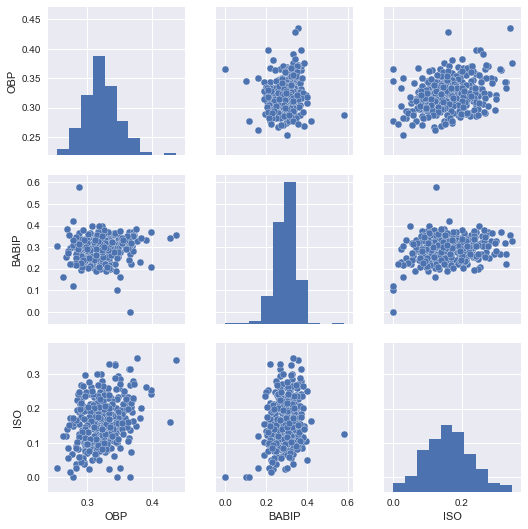

In [275]:
# dfb['Drafted'] = dfb['Squad'].isnull()

sb.pairplot(dfb[['OBP', 'BABIP', 'ISO']].dropna())